In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

import sys
import os
from os import listdir
from os.path import isfile, join

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Dense, Conv1D



%matplotlib inline

Using TensorFlow backend.


In [3]:
full_data = pd.read_csv('../../data/train.csv')
test_data = pd.read_csv('../../data/test.csv')

In [4]:
def chunk_data(data, number_of_chunks):
    chunks = list()
    lst = np.linspace(0, len(data), number_of_chunks + 1, dtype = int)
    for start, stop in zip(lst[0:-1], lst[1:]):
        chunks.append(data[start:stop].copy())
    return chunks

def linear_transform(data, slope, intercept):
    data = data.copy()
    data['signal'] = data['signal'] - (slope * data['time'] + intercept)
    return data

def parabolic_transform(data, h, k):
    '''
    vertex formula of parabola (a * (x- h) ^ 2 + k)
    a is the steepnes (same as a in standard form)
    h is the x value of the vertex (time of the center of the chunk)
    k is the y value of the vertex
    
    a = -k / 625
    '''
    data = data.copy()
    data['signal'] = data['signal'] - ((-k / 625) * (data['time'] - h) ** 2 + k)
    return data

Text(0.5, 1.0, 'Train Data Signal Without Drift')

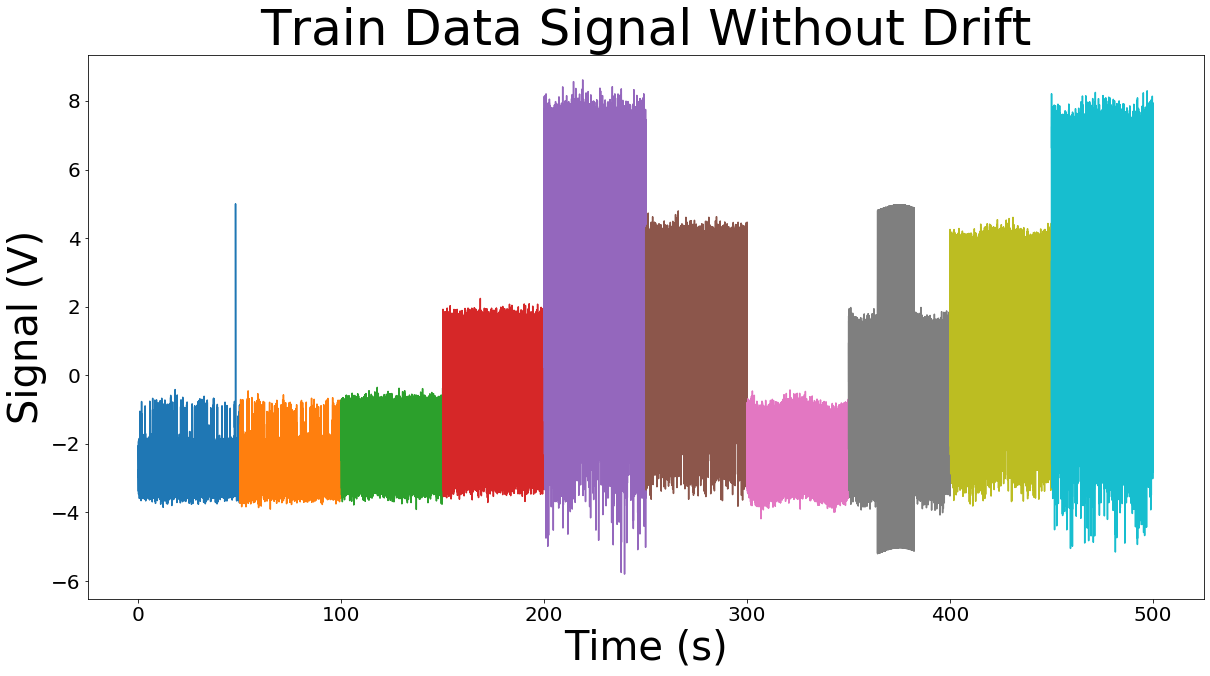

In [26]:
train_chunks = chunk_data(full_data, 10)

train_chunks[1][:100000] = linear_transform(train_chunks[1][:100000], 3 / 10, -15)
train_chunks[6] = parabolic_transform(train_chunks[6], 325, 5.003)
train_chunks[7] = parabolic_transform(train_chunks[7], 375, 5.030)
train_chunks[8] = parabolic_transform(train_chunks[8], 425, 4.974)
train_chunks[9] = parabolic_transform(train_chunks[9], 475, 5.089)

plt.figure(figsize = (20, 10))
for i in train_chunks:
    plt.plot(i['time'], i['signal']) 

plt.xlabel('Time (s)', fontsize = 40)
plt.xticks(fontsize = 20)
plt.ylabel('Signal (V)', fontsize = 40)
plt.yticks(fontsize = 20)
plt.title("Train Data Signal Without Drift", fontsize = 50)
#plt.savefig('chunked_training_removed_drifts')

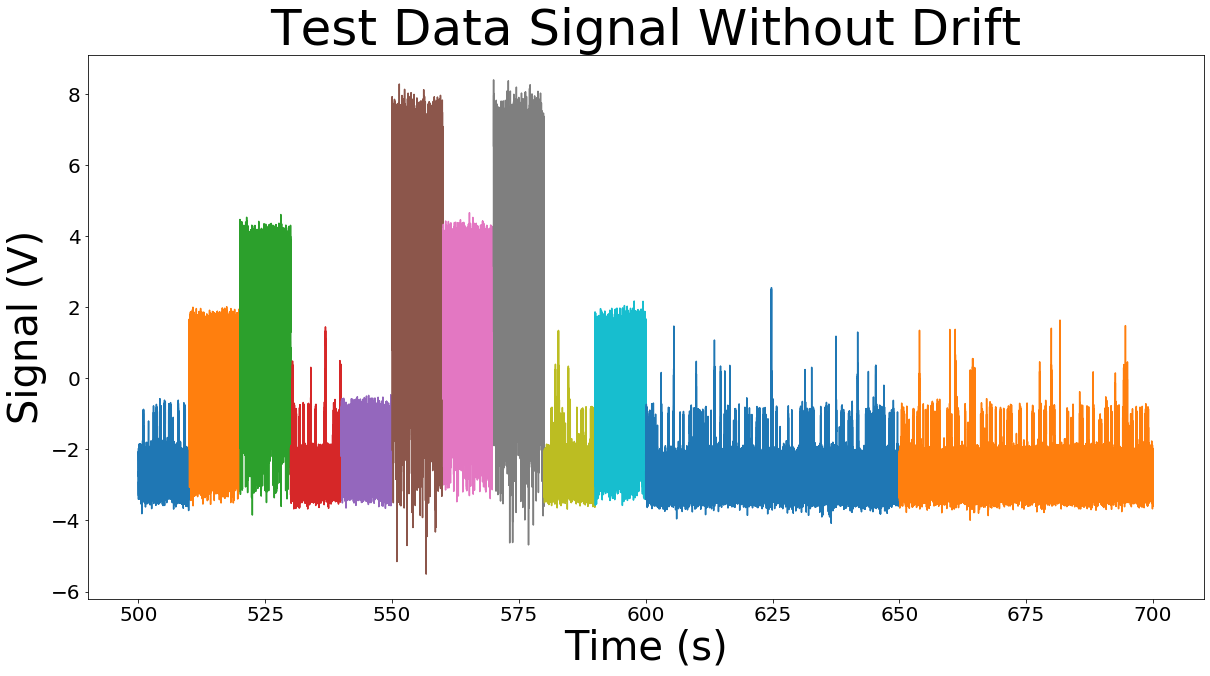

In [30]:
test_chunks = chunk_data(test_data, 4)
test_chunks = chunk_data(test_chunks[0], 5) + chunk_data(test_chunks[1], 5) + test_chunks[2:]

test_chunks[0] = linear_transform(test_chunks[0], 3 / 10, -150)
test_chunks[1] = linear_transform(test_chunks[1], 3 / 10, -153)
test_chunks[4] = linear_transform(test_chunks[4], 3 / 10, -162)
test_chunks[6] = linear_transform(test_chunks[6], 3 / 10, -168)
test_chunks[7] = linear_transform(test_chunks[7], 3 / 10, -171)
test_chunks[8] = linear_transform(test_chunks[8], 3 / 10, -174)
test_chunks[10] = parabolic_transform(test_chunks[10], 625, 4.925)
test_chunks[10]['signal'] -= test_chunks[10]['time'].apply(lambda x: - 0.15 * math.sin(math.pi * 3 * x / 50))

test_chunks = test_chunks[:10] + chunk_data(pd.concat(test_chunks[10:]), 10)

plt.figure(figsize = (20, 10))


for i in test_chunks:
    plt.plot(i['time'], i['signal'])
    
plt.xlabel('Time (s)', fontsize = 40)
plt.xticks(fontsize = 20)
plt.ylabel('Signal (V)', fontsize = 40)
plt.yticks(fontsize = 20)
plt.title("Test Data Signal Without Drift", fontsize = 50)
#plt.savefig('Test_Data_Signal_without_drift')


In [7]:
model1_data = pd.concat([train_chunks[0], train_chunks[1]])
model2_data = pd.concat([train_chunks[2], train_chunks[6]])
model3_data = pd.concat([train_chunks[3], train_chunks[7]])
model4_data = pd.concat([train_chunks[5], train_chunks[8]])
model5_data = pd.concat([train_chunks[4], train_chunks[9]])

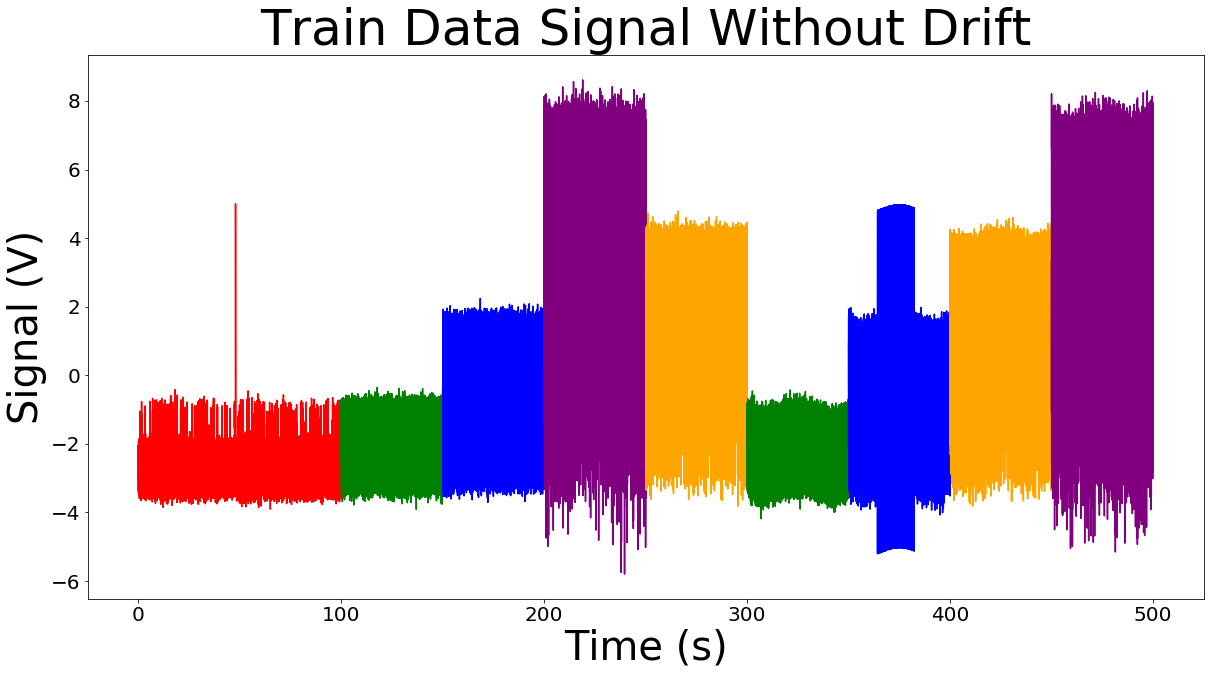

In [23]:
plt.figure(figsize = (20, 10))
colors = [1,1,2,3,5,4,2,3,4,5]
color_letter = ['','r','g','b','orange','purple']
for i, color in zip(train_chunks, colors):
    plt.plot(i['time'], i['signal'], color = color_letter[color])
    #plt.plot(i['time'], i['open_channels'].rolling(10000).mean() + 5, color = color_letter[color]) 

plt.xlabel('Time (s)', fontsize = 40)
plt.xticks(fontsize = 20)
plt.ylabel('Signal (V)', fontsize = 40)
plt.yticks(fontsize = 20)
plt.title("Train Data Signal Without Drift", fontsize = 50)
plt.savefig('chunked_training_removed_drift_waveforms')

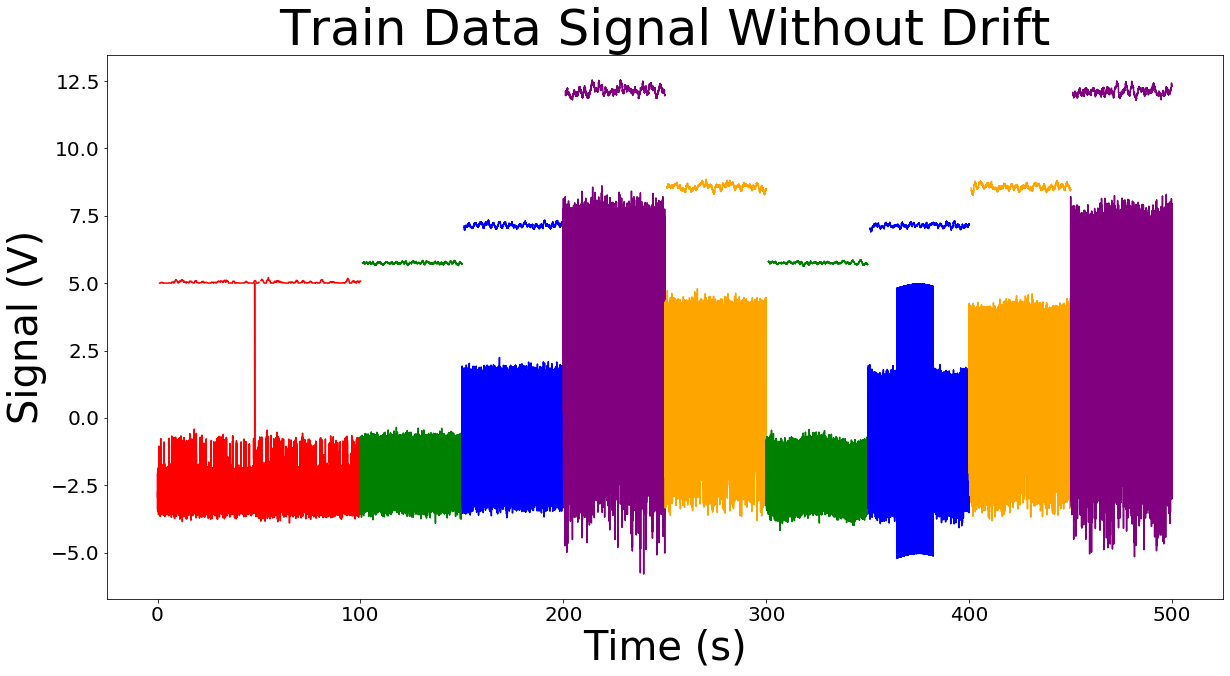

In [24]:
plt.figure(figsize = (20, 10))
colors = [1,1,2,3,5,4,2,3,4,5]
color_letter = ['','r','g','b','orange','purple']
for i, color in zip(train_chunks, colors):
    plt.plot(i['time'], i['signal'], color = color_letter[color])
    plt.plot(i['time'], i['open_channels'].rolling(10000).mean() + 5, color = color_letter[color]) 

plt.xlabel('Time (s)', fontsize = 40)
plt.xticks(fontsize = 20)
plt.ylabel('Signal (V)', fontsize = 40)
plt.yticks(fontsize = 20)
plt.title("Train Data Signal Without Drift", fontsize = 50)
plt.savefig('chunked_training_removed_drift_waveforms_with_opens')

In [139]:
def get_model(data):
    model = RandomForestClassifier(n_estimators = 20)
    model.fit(data['signal'].values.reshape((-1, 1)), data['open_channels'].values)
    return model

In [38]:
model1 = make_model(model1_data)
model2 = make_model(model2_data)
model3 = make_model(model3_data)
model4 = make_model(model4_data)
model5 = make_model(model5_data)

In [41]:
f1_score(model1_data['open_channels'], predict(model1, model1_data)['open_channels'], average = 'macro')

0.9895406486804256

In [42]:
f1_score(model2_data['open_channels'], predict(model2, model2_data)['open_channels'], average = 'macro')

0.9961045877393143

In [40]:
def predict(model, test_data):
    y_predictions = model.predict(test_data['signal'].values.reshape((-1, 1)))
    return pd.DataFrame({'time' : test_data['time'].values, 'open_channels' : y_predictions})

In [43]:
predictions = pd.DataFrame(columns = ['time', 'open_channels'])
predictions = pd.concat([predictions, predict(model1, test_chunks[0])])
predictions = pd.concat([predictions, predict(model3, test_chunks[1])])
predictions = pd.concat([predictions, predict(model4, test_chunks[2])])
predictions = pd.concat([predictions, predict(model1, test_chunks[3])])
predictions = pd.concat([predictions, predict(model2, test_chunks[4])])
predictions = pd.concat([predictions, predict(model5, test_chunks[5])])
predictions = pd.concat([predictions, predict(model4, test_chunks[6])])
predictions = pd.concat([predictions, predict(model5, test_chunks[7])])
predictions = pd.concat([predictions, predict(model1, test_chunks[8])])
predictions = pd.concat([predictions, predict(model3, test_chunks[9])])
predictions = pd.concat([predictions, predict(model1, test_chunks[10])])
predictions = pd.concat([predictions, predict(model1, test_chunks[11])])
predictions = pd.concat([predictions, predict(model1, test_chunks[12])])
predictions = pd.concat([predictions, predict(model1, test_chunks[13])])
predictions = pd.concat([predictions, predict(model1, test_chunks[14])])
predictions = pd.concat([predictions, predict(model1, test_chunks[15])])
predictions = pd.concat([predictions, predict(model1, test_chunks[16])])
predictions = pd.concat([predictions, predict(model1, test_chunks[17])])
predictions = pd.concat([predictions, predict(model1, test_chunks[18])])
predictions = pd.concat([predictions, predict(model1, test_chunks[19])])

In [44]:
predictions.to_csv('~/Desktop/test_predictions.csv', index = False, float_format='%.4f')
#0.916